# Модель микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

In [65]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('DB', 'bankrp.sqlite3')
strDB_YEAR_path=path.join('DB', 'year.sqlite3')

# константы базы данных SQLite3
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_data_pass='noza_columns' # таблица с названиями колонок для таблицы noza
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)

# ------------

# пути и константы для данных из Excel-версии модели и базы данных
strModelSource=path.join('.', 'DB', 'SRC', 'Долгосрочная модель.xlsx')
strMargaSheet='Новостройки'
strModelSheet='Модель'
strStrojKomplex='Стройкомплекс'
#---------------

strMD='''
<div class="alert alert-block alert-success">
<b>База данных - {bd_path}<br>
<a href="{bankrupt_prob_DB}?DATABASE={bd_path}" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>
'''.format(bankrupt_prob_DB='bankrupt_prob_DB.ipynb', bd_path=strDB_path)
md(strMD)


<div class="alert alert-block alert-success">
<b>База данных - DB/bankrp.sqlite3<br>
<a href="bankrupt_prob_DB.ipynb?DATABASE=DB/bankrp.sqlite3" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>


## Подготовка данных

 
  1. **Чтение данных из базы данных (таблицы SPARK, NOZA и LOAN).** Данные читаются посредством запросов, созданных на этапе созднания базы данных. Первичный счет показателей осуществляется в этих запросах. При желании можно загрузить данные непосредственно из таблиц, для этого надо поменять название таблицы в строке запроса, в коде, в данном блокноте. Однако вычисления на стороне базы данных несколько быстрее, чем вычисления в коде.   
  2. **Чтение данных из "Долгосрочной модели".** Эти данные предполагается в будущем моделировать в Питоне, однако в настоящий момент они берутся из модели в файле Excel. Эти данные необходимы для построения и расчета промежуточных под-моделей, используемых в основном блоке расчета модели банкротств  
  3. **Построение и расчет промежуточных под-моделей**. Под-модели используются в качестве поставщиков данных для основной модели

### Чтение данных из базы

Даные из таблицы NOZA читаются запросом noza_agg. В запросе данные группируются по ИНН застройщика, по году сдачи проекта, суммируются цены проектов и вводимая жилая площадь построек (т.е. считается суммарная стоимость всех проектов и вся вводимая жилая площадь каждого застройщика в год).  


Данные из таблицы SPARK читаются запросом spark_ag. В запросе расчитывается показатель Z_A: 
`модуль((Кредиторская задолженность - Дебиторская задолженность) / Активы всего)`.

Показатель ROA берется из базы данных, одноко он так же может расчитываться по формуле `Чистая прибыль/Активы всего` (для этого надо использовать запрос spark_ag_roa_calc)


Данные из таблицы LOAN читаются запросом loan_agg. Расчеты выполняются в блокноте

In [53]:
strSELECT_NOZA='select * from {noza_table}'.format(noza_table=strNOZA_agg)
strSELECT_spark='select * from {spark_table}'.format(spark_table=strSPARK_agg)
strSELECT_LOAN='select * from {loan_table}'.format(loan_table=strLOAN_agg)

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных


из таблицы NOZA берем только последнюю точку по дате публикации

In [54]:
pdfNoza=pd.read_sql(strSELECT_NOZA, con=conWork)
pdfNoza['pub_date']=pd.to_datetime(pdfNoza['pub_date'], format='%Y-%m-%d')
pdfNoza.sort_values(by='pub_date', ascending=False)
pdfNoza=pdfNoza.loc[pdfNoza['pub_date']==pdfNoza['pub_date'].max(), (c for c in pdfNoza.columns if c !='pub_date')] # берем последнюю по дате публикации точку - теоретически возможно хранить в БД несколько временных точек
print(pdfNoza.shape)
pdfNoza.head()

(4616, 4)


,inn,completion_year,price,square
0,0105003792,2020,367349984,9327.82
1,0105008695,2020,284736960,6943.00
2,0106003795,2020,249000000,9639.37
3,0107008891,2020,98972928,4680.96
4,0107022575,2020,582293936,18055.21


In [55]:
pdfSPARK=pd.read_sql(strSELECT_spark, con=conWork)
pdfSPARK.replace({None:np.nan}, inplace=True)
pdfSPARK['Cancel_date']=pd.to_datetime(pdfSPARK['Cancel_date'])
print(pdfSPARK.shape)
pdfSPARK.head()

(103968, 6)


,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2013,NaN,NaT,NaN,NaN
1,3801132195,2013,NaN,NaT,NaN,NaN
2,5050102110,2013,10000.0,NaT,NaN,0.633592
3,7448046410,2013,NaN,NaT,NaN,NaN
4,1840032987,2013,NaN,NaT,NaN,NaN


в таблице loan считаем среднюю ставку за год 

In [56]:
pdfLOAN=pd.read_sql(strSELECT_LOAN, con=conWork)

pdfLOAN['date']=pd.to_datetime(pdfLOAN['date'], format='%Y-%m-%d')
pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y'))['loan_nonfin'].mean()

date
2014-12-31    11.135000
2015-12-31    15.716667
2016-12-31    12.592500
2017-12-31    10.560000
2018-12-31     8.866667
2019-12-31     8.753333
2020-12-31     7.554000
Freq: A-DEC, Name: loan_nonfin, dtype: float64

## Загрузка данных из долгосрочной модели


<div class="alert alert-block alert-info">
    Фактические даные - из базы данных с годовыми рядами - распологается локально, файл ./DB/year.sqlite3<br>
    Прогнозные данные - excel-файл с долгосрочной моделью - располагается локально, в каталоге ./DB/SRC<br>
    Чтобы использовать последнюю версию модели сохранить  файл с моделью с расширением xlsx и загрузить его по этому пути
</div>

Эти данные используются для расчета под-моделей: моделирования средней по отрасли рентабельности застройщиков и ...

Читаем:  
   - Изменение среднесписочной численности работников (лист Модель, строка 493; или лист Стройкомплекс, строка 13; фактические данные из year.sqlite3, код 69)
   - Индекс физобъема выпуска (лист Модель, строка 489; или лист Стройкомплекс, строка 6; фактические данные из year.sqlite3, код 65))
   - Маржа прибыли застройщиков (лист Новостройки, строка 10)
   - Индексы номинальных цен на рынке жилья, на вторичном рынке (лист Модель, строка 687, делить на 100; фактические данные из year.sqlite3, код 116))
   
### Читаем фактические данные из базы данных

In [112]:
lst_work_columns=['I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market', 'marga']

strSQL_year_SELECT='select * from datas where code in (65, 69, 116, 131, 52)'

strDB_YEAR_path

conYear = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_YEAR_path))

pdfYear=pd.read_sql(strSQL_year_SELECT, con=conYear).set_index(['date', 'code']).unstack(level=1)

# pdfYear.columns=['I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market']
pdfYear.rename(columns={65:'I_phyvol_issue', 69:'Chng_avrg_num_empls', 116:'I_nom_prices_sec_market', 
                       52:'цена ДДУ', 131:'стоимость строительства жилья'}, 
              inplace=True)

pdfYear.columns=[cn[1] for cn in pdfYear.columns]

pdfYear['marga']=pdfYear['стоимость строительства жилья']/pdfYear['цена ДДУ']
pdfYear=pdfYear[lst_work_columns]
pdfYear.index=pdfYear.index.astype(int)
pdfYear

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
date,,,,
2004,1.101,NaN,NaN,1.493010
2005,1.132,NaN,NaN,1.531764
2006,1.181,NaN,1.3684,1.663389
2007,1.182,1.029933,1.3389,1.884944
2008,1.128,1.064991,1.1954,1.716113
2009,0.868,0.923699,0.9455,1.434751
2010,1.050,0.960931,0.9843,1.343579
2011,1.051,1.007171,1.0827,1.137379
2012,1.025,1.016925,1.1524,1.210883


### Читаем прогнозные данные из файла Excel (долгосрочная модель)

In [135]:
# для чтения данных из листа Модель
pdfXLS_model=pd.read_excel(strModelSource, sheet_name=strModelSheet, usecols='B, G:AZ', 
                           skiprows=[i for i in range(1500) if i not in [2, 686, 492, 488]], index_col=0)
pdfXLS_model=pdfXLS_model.T
print('Прочитано из файла ексель', pdfXLS_model.shape)
# print(pdfXLS_model.head())
#==========================
# для чтения данных из листа Стройкомплекс
# pdfXLS_strojK=pd.read_excel(strModelSource, sheet_name=strStrojKomplex, usecols='A, F:BZ', 
#                            skiprows=[i for i in range(1500) if i not in [1, 5, 12]], index_col=0)

# pdfXLS_model=pdfXLS_strojK.T
# print(pdfXLS_model)
# #=========================================

print('Прочитано из файла ексель', pdfXLS_model.shape)


print('Читаем маржу из листа Новостройки, добавляем во фрейм', end='...')
pdfXLS_model['marga']=pd.read_excel(strModelSource, sheet_name=strMargaSheet, usecols='B, K:AZ',
                      skiprows=[i for i in range(255) if i not in [0, 9, 10]], 
                      index_col=0).loc['маржа прибыли застройщиков'] / 100
print('сделано - ', pdfXLS_model.shape)
print('Переименовывыние колонок для удоства использования', end='...')
pdfXLS_model.columns=lst_work_columns

print('сделано')
pdfXLS_model=pdfXLS_model.dropna(how='all')
pdfXLS_model.index=pdfXLS_model.index.astype(int)
pdfXLS_model

Прочитано из файла ексель (28, 3)
Прочитано из файла ексель (28, 3)
Читаем маржу из листа Новостройки, добавляем во фрейм...сделано -  (28, 4)
Переименовывыние колонок для удоства использования...сделано


,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
2009,NaN,NaN,0.945500,1.434751
2010,1.050000,0.960931,0.984300,1.343579
2011,1.051000,1.007171,1.082700,1.137379
2012,1.025000,1.016925,1.152400,1.210883
2013,1.001000,0.987682,1.078200,1.210797
2014,0.977000,0.978279,1.062000,1.148896
2015,0.961000,0.960882,0.987700,1.179112
2016,0.979000,0.973983,0.958900,1.164349
2017,0.989000,0.973601,0.976600,1.214532
2018,1.063000,0.992443,1.015800,1.299932


### Объединение фактических и прогнозных значений

In [136]:
pdfXLS_model=pdfXLS_model.append(pdfYear).reset_index().drop_duplicates('index', keep='last').sort_values('index').rename(columns={'index':'year'}).set_index('year')[lst_work_columns]
pdfXLS_model.head()

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
year,,,,
2004,1.101,NaN,NaN,1.493010
2005,1.132,NaN,NaN,1.531764
2006,1.181,NaN,1.3684,1.663389
2007,1.182,1.029933,1.3389,1.884944
2008,1.128,1.064991,1.1954,1.716113


In [144]:
pdfSPARK

,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2013,NaN,NaT,NaN,NaN
1,3801132195,2013,NaN,NaT,NaN,NaN
2,5050102110,2013,10000.0,NaT,NaN,0.633592
3,7448046410,2013,NaN,NaT,NaN,NaN
4,1840032987,2013,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...
103963,6213013559,2019,80000000.0,NaT,0.0107,0.739784
103964,2221204292,2019,80000000.0,NaT,0.0012,0.066570
103965,7017342291,2019,NaN,NaT,NaN,NaN
103966,5603041609,2019,10000.0,NaT,1.0899,NaN


## Построение и расчет промежуточных моделей

### Подготовка данных для моделирования

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    x - предикторы прогнозных значений<br>
    Y - известные объясняемые значения<br>
    y - прогнозные объясняемые значения<br>
    </b>
</div>
    
К `X` и `x` добавляется **интерсептор**. Переменная `lag` задает сдвиг (положительное значение - вправо, отрицательное - влево)

   `pdfSubModResult` - датафрейм с результатами расчета под-моделей

In [154]:
def prepare_x_data(pdfX, print_pars=False, lag=0):
    X_=pdfX.shift(lag).dropna()
    X_=sm.add_constant(X_, prepend=False)

    if print_pars:
        print('X = \n', X_)
        print('-'*40)
    return X_

def prepare_fit_data(pdfY, pdfX, print_pars=False, lag=0):
    """Возвращает X, Y и x для обучения (оценки) модели"""
    Y_=pdfY.groupby(by='year').agg(np.median)
    Y_.rename(columns={ Y_.columns[0]: '{}, факт'.format(Y_.columns[0]) }, inplace = True)
    X_ = prepare_x_data(pdfX, lag=lag)

    X=X_.loc[X_.index.intersection(Y_.index, sort=None)]
    Y=Y_.loc[Y_.index.intersection(X_.index, sort=None)]
    x=X_.loc[X_.index.difference(Y_.index)].dropna()
    x=x[x.index>Y.index.max()]
    if print_pars:
        print('X = \n', X)
        print('-'*40)
        print('Y = \n', Y)
        print('-'*40)
        print('x = \n', x)
        print('-'*40)
    return X, Y, x

pdfSubModResult=pd.DataFrame(pdfXLS_model.dropna(how='all').index.astype('int64'), columns=['year',]).set_index('year')
# pdfSubModResult=pdfXLS_model
# pdfSubModResult
# X_roa, Y_roa, x_roa=prepare_fit_data(pdfSPARK[['year', 'ROA']].copy(), 
#                          pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=True)

# prepare_x_data(pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=True, lag=1)


### Модель *Рентабельность застройщиков, медиана по отрасли  (ROA)*
<br>
<center>$\overline{ROA}$ ~ $I\_nom\_prices\_sec\_market$ + $marga$ + $1$</center>

<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индексы номинальных цен на рынке жилья, на вторичном рынке (<i>I_nom_prices_sec_market</i>, из данных Долгосрочной модели)</li>
        <li>Маржа прибыли застройщиков (<i>marga</i>, из данных Долгосрочной модели)</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли рентабельность застройщика (<i>ROA</i> датафрейма <i>pdfSPARK</i>)
</div>

In [159]:
X_roa, Y_roa, x_roa=prepare_fit_data(pdfSPARK[['year', 'ROA']].copy(), 
                         pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=False)

resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

print(resROA.summary())

                            OLS Regression Results                            
Dep. Variable:              ROA, факт   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4.983
Date:                Tue, 25 Aug 2020   Prob (F-statistic):             0.0349
Time:                        19:37:43   Log-Likelihood:                 66.098
No. Observations:                  12   AIC:                            -126.2
Df Residuals:                       9   BIC:                            -124.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
I_nom_prices_sec_market   

In [160]:
Ym_roa=pd.DataFrame(resROA.predict(), index=X_roa.index, columns=['ROA, модель'])
y_roa=pd.DataFrame(resROA.predict(x_roa), columns=['ROA, прогноз'])

# для графика - соединяем последнюю точку модели и первую прогноза
Ym_roa.loc[y_roa.index.tolist()[0]]=y_roa.iloc[0].values 

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[Y_roa.index, 'ROA_']=Y_roa.iloc[:, 0]
pdfSubModResult.loc[y_roa.index, 'ROA_']=y_roa.iloc[:, 0]
# pdfSubModResult

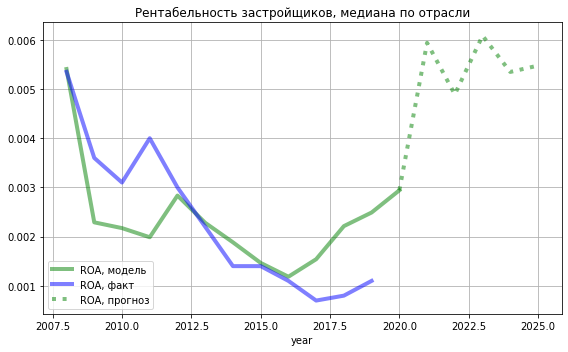

In [161]:
ax_roa=Ym_roa.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Рентабельность застройщиков, медиана по отрасли', color='g')
Y_roa.plot.line(ax=ax_roa, color='b', linewidth=4, alpha=0.5)
y_roa.plot.line(ax=ax_roa, color='g', style=':', linewidth=4, alpha=0.5, grid=True)
# pdfSubModResult.dropna().plot.line(ax=ax_roa, style='.-', color='maroon', linewidth=14, alpha=0.2)
plt.tight_layout()
plt.show();

### Модель *Чистая кредиторская задолженность (по модулю), медиана по отрасли (Z_A)*
<br>
<center>$\overline{Z\_A}$ ~ $I\_phyvol\_issue_{y-1} + Chng\_avrg\_num\_empls_{y-1} + 1$</center>
<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индекс физобъема выпуска (<i>I_phyvol_issue</i>, из данных Долгосрочной модели, с лагом 1 год)</li>
        <li>Изменение среднесписочной численности работников (<i>Chng_avrg_num_empls</i>, из данных Долгосрочной модели, с лагом 1 год))</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли Чистая кредиторская задолженность(<i>Z_A</i> датафрейма <i>pdfSPARK</i>)
</div>

In [162]:
# если в функцииниже поставить lag=0 то будет оценка и прогноз БЕЗ лагов. 
# ИМХО график (до него надо до-выполнить все ячейки после изменения лага) выглядит честнее


X_za, Y_za, x_za=prepare_fit_data(pdfSPARK[['year', 'Z_A']].copy(), 
                                  pdfXLS_model[['I_phyvol_issue', 'Chng_avrg_num_empls']].copy(), lag=1)

resZ_A = sm.OLS(Y_za, X_za, missing='drop').fit()

print(resZ_A.summary())

                            OLS Regression Results                            
Dep. Variable:              Z_A, факт   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     2.870
Date:                Tue, 25 Aug 2020   Prob (F-statistic):              0.109
Time:                        19:37:56   Log-Likelihood:                 43.438
No. Observations:                  12   AIC:                            -80.88
Df Residuals:                       9   BIC:                            -79.42
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
I_phyvol_issue         -0.1246    

In [163]:
Ym_za=pd.DataFrame(resZ_A.predict(), index=X_za.index, columns=['Z_A, модель'])
y_za=pd.DataFrame(resZ_A.predict(x_za), columns=['Z_A, прогноз'])[:-1]

# для графика - соединяем последнюю точку модели и первую прогноза
Ym_za.loc[y_za.index.tolist()[0]]=y_za.iloc[0].values 

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[Y_za.index, 'Z_A_']=Y_za.iloc[:, 0]
pdfSubModResult.loc[y_za.index, 'Z_A_']=y_za.iloc[:, 0]
# pdfSubModResult

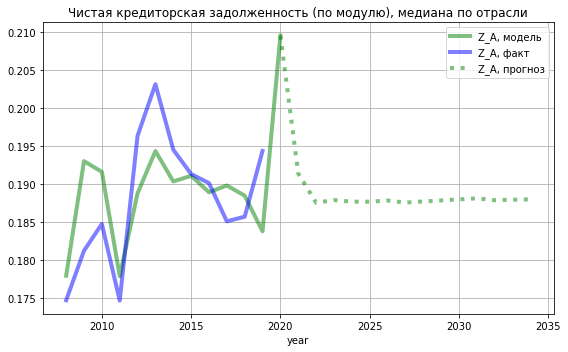

In [164]:
ax_za=Ym_za.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Чистая кредиторская задолженность (по модулю), медиана по отрасли', color='g')
Y_za.plot.line(ax=ax_za, color='b', linewidth=4, alpha=0.5)
y_za.plot.line(ax=ax_za, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult['Z_A_'].dropna().plot.line(ax=ax_za, color='grey', linewidth=14, alpha=0.3)

plt.tight_layout()
plt.show();

### Модель *Ставка по кредитам*

<div class="alert alert-block alert-danger">
    <b>ЭТОГО ПОКА НЕТ</b>
</div>


<AxesSubplot:xlabel='date'>

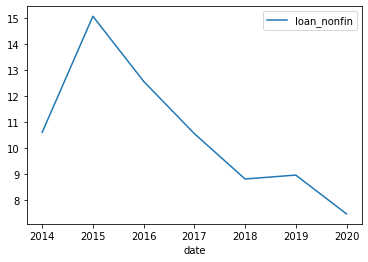

In [165]:
pdf=pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y')).agg(np.median)
pdf.index=pdf.index.year
pdf.plot.line()

## Оценка и расчет основной модели "Банкротства застройщиков"
<br>
<center>$Y$ ~ $\overline{ROA}_{y-1} + \overline{Z\_A}_{y-1} + \overline{LOAN}_{y-1} + Ln(capital) + 1$</center>


<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Ставка по кредитам (<i>LOAN_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли рентабельность застройщика (<i>ROA_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли Чистая кредиторская задолженность(<i>Z_A_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>        
        <li>Уставной капитал, ln от тыс.руб.(<i>Capital</i> датафрейма <i>pdfSPARK</i>)</li>
    </ul><br>
    <b>Объясняемая переменная</b> - год банкротства компании (<i>Cancel_date</i> датафрейма <i>pdfSPARK</i>, ненулевая дата соответствует событию "банкротство")<br><br>
    Переменная <b>fBnkrp_Level</b> задает порог отсечки события (превышение порога - предприятие банкрот).
</div>

Для прогноза данные датафрейма `pdfSPARK` продлеваются (копируются построчно) на прогнозные года (данные беруться из последнего, максимального для всех записей года. 

Потом полученный датафрейм комбинируется с датафреймом `pdfSubModResult`  
При совпадении значений в полях `year` и года в `Cancel_date` в поле `Cancel_date` ставится `1` - индикатор события. Последующие года для даного `inn` в моделированиине участвуют - компания считается банкротом

In [166]:
fBnkrp_Level=7e-3 # уровень порога события "банкротство"

def prepare_fin_bnkrp_data(pdfS, pdfSubModR, lag=1):
    """подготовка данных для моделирования банкротств
       1. к базе данных SPARK добавляем годы до горизонта прогноза 
       2. Для этого для каждого inn копируем существующие данные последнего (максимального для всех) года
       3. для каждого inn и каждого года вписываем значения из результатов под-моделей
    """
    iForYears=pdfSubModR.shift(lag).dropna().reset_index()['year'].max()-pdfS['year'].max()
    pdf=pdfSPARK[['inn','year', 'capital', 'Cancel_date']]
    
    for i in range(iForYears):
        pdf1=pdf[pdf['year']==pdf['year'].max()]

        pdf1['year']=pdf1['year']+1
        pdf=pdf.append(pdf1)
    pdf_tmp=pdfSubModR.dropna().combine_first(pdf.set_index('year')).reset_index()
    pdf_tmp['Cancel_date']=pd.to_datetime(pdf_tmp['Cancel_date'])
    
    pdf_tmp=pdf_tmp.set_index(['inn', 'year'])

    # заполняем пропущенные данные для уставного капитала предидущими значениями для того же ИНН
    pdf_tmp['capital']=pdf_tmp.groupby(level=0)['capital'].fillna(method='ffill')
    
    pdf_tmp['Y']=0 # колонка с событием
    
    # выставляем "1" в годе, соответствующим банкротству для данного ИНН
    _pdf_t=pdf_tmp.groupby('inn')['Cancel_date'].min().dt.year.dropna()
    
    for k, v in _pdf_t.iteritems():
        pdf_tmp.loc[(k, int(v)), 'Y']=1
    
    return pdf_tmp.reset_index() #.sort_values(by=['inn', 'year'])


# на выходе получаем X - это ROA, Z_A, capital по каждому году и каждому ИНН до горизонта прогноза
# Y - признак события = 1 в годе банкротства
pdf_model=prepare_fin_bnkrp_data(pdfSPARK, pdfSubModResult)
pdf_model.head()

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y
0,3906245291,2008,NaT,0.00535,0.174666,NaN,0.0
1,3801132195,2008,NaT,0.00535,0.174666,NaN,0.0
2,5050102110,2008,NaT,0.00535,0.174666,NaN,0.0
3,7448046410,2008,NaT,0.00535,0.174666,NaN,0.0
4,1840032987,2008,NaT,0.00535,0.174666,NaN,0.0


#### Создаем фреймы X, x, Y, y

  - Убираем из фрейма входных данных для модели строки с пустыми значениями
  - X и Y получаем из фрейма входных данных, выбирая все строки, в которых даты (годы) меньше максимального года в поле `Cancel_date` (поле в котором записана фактическая дата банкротства компании)
  - x и y - строки из фрейма входных данных, у которых дата (год) больше максимального фактического года банкротства компании из фактических данных

In [167]:
pdf_not_zero_mask=pdf_model[['ROA_', 'Z_A_', 'capital']].fillna(0).all(axis=1, skipna=True)

pdf_X=pdf_model.loc[pdf_not_zero_mask & (pdf_model['year']<=np.max(pdfSPARK['Cancel_date'].dt.year))]
pdf_x=pdf_model.loc[pdf_not_zero_mask & (pdf_model['year']>np.max(pdfSPARK['Cancel_date'].dt.year))]
pdf_x=pdf_x.loc[~pdf_x['inn'].isin(pdf_X.loc[~pdf_X['Cancel_date'].notnull(), 'inn'].unique())]

pdf_X.head()

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y
13,7701651356,2008,NaT,0.00535,0.174666,50000.0,0.0
15,7725038614,2008,NaT,0.00535,0.174666,12000.0,0.0
17,7714726658,2008,2020-07-21,0.00535,0.174666,10000.0,0.0
18,7807020417,2008,NaT,0.00535,0.174666,110000.0,0.0
20,7703037783,2008,NaT,0.00535,0.174666,4000.0,0.0


<div class="alert alert-block alert-danger">
    <b>Надо бы еще сделать отсечку: если есть (либо фактическая, либо модельная) дата ликвидации, то для даной компании все строки, с датой больше даты ликвидации - удалить. То есть удалить все, что после банкротства</b>
    <br>
    <b>Еще наверное надо сделать прогноз (расчет y) - прогонять по годам. 2020, потом 2021 и т.д. И удалять всех банкротов из последующих годов.</b>
</div>

#### Строим модель банкротств



In [168]:
import statsmodels.formula.api as smf

# bnkr_model = sm.GLM.from_formula("Y ~ ROA_ + Z_A_ + np.log(capital)", family=sm.families.Binomial(), data=pdf_X)
bnkr_model = smf.logit("Y ~ ROA_ + Z_A_ + np.log(capital)", data=pdf_X)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

         Current function value: 0.046314
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                66862
Model:                          Logit   Df Residuals:                    66858
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                 0.05689
Time:                        19:39:00   Log-Likelihood:                -3096.7
converged:                      False   LL-Null:                       -3283.5
Covariance Type:            nonrobust   LLR p-value:                 1.153e-80
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -33.6472      3.115    -10.803      0.000     -39.752     -27.543
ROA_            -1937.0313    187.005    -10.358  

#### Проверка по историческим данным

Если в некотором годе вероятность банкротства по модели больше заданного уровня (`fBnkrp_Level`), компания считается банкротом (флаг Y_p устанавливается в 1)

In [169]:
pdf_X['Y_p']=(bnkr_result.predict(pdf_X)>=fBnkrp_Level).astype(int)
pdf_X

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
13,7701651356,2008,NaT,0.005350,0.174666,50000.0,0.0,0
15,7725038614,2008,NaT,0.005350,0.174666,12000.0,0.0,0
17,7714726658,2008,2020-07-21,0.005350,0.174666,10000.0,0.0,0
18,7807020417,2008,NaT,0.005350,0.174666,110000.0,0.0,0
20,7703037783,2008,NaT,0.005350,0.174666,4000.0,0.0,0
...,...,...,...,...,...,...,...,...
112627,6213013559,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112628,2221204292,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112629,7017342291,2020,NaT,0.002941,0.209570,50284000.0,0.0,0
112630,5603041609,2020,NaT,0.002941,0.209570,10000.0,0.0,1


#### Прогноза банкротств на заданный горизонт

In [170]:
i_start=dt.datetime.now().year
i_horizont=i_start+3

# bnkr_result.predict()
pdf_x['Y_p']=(bnkr_result.predict(pdf_x)>=fBnkrp_Level).astype(int)
pdf_x


,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
112653,3905610382,2021,2019-12-17,0.005940,0.191393,10000.0,0.0,0
112692,5530005074,2021,2020-03-23,0.005940,0.191393,10000.0,0.0,0
112718,5503031981,2021,2019-12-18,0.005940,0.191393,10000.0,0.0,0
112745,7723186303,2021,2020-07-02,0.005940,0.191393,10000.0,0.0,0
112767,7722535569,2021,2018-12-27,0.005940,0.191393,10000.0,0.0,0
...,...,...,...,...,...,...,...,...
155878,0816006455,2025,2020-01-28,0.005477,0.187667,10000.0,0.0,0
155879,7424031171,2025,2019-12-27,0.005477,0.187667,10000.0,0.0,0
155883,6140038767,2025,2020-04-30,0.005477,0.187667,20000.0,0.0,0
155938,7604068205,2025,2019-04-02,0.005477,0.187667,10000.0,0.0,0


In [171]:
pdf_x.loc[pdf_x['Y_p']==1]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p


In [172]:

pdf_X.loc[(pdf_X['Y']!=0) & (pdf_X['Y_p']!=pdf_X['Y'])]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
38814,2722057514,2012,2012-06-21,0.003000,0.196358,10000.0,1.0,0
63996,2012002172,2015,2015-07-13,0.001400,0.191316,12010000.0,1.0,0
65335,2315143895,2015,2015-09-17,0.001400,0.191316,100000.0,1.0,0
68678,6228040280,2015,2015-09-03,0.001400,0.191316,10200000.0,1.0,0
69790,6901024343,2016,2016-12-27,0.001100,0.190117,30678000.0,1.0,0
...,...,...,...,...,...,...,...,...
111893,8911001194,2020,2020-03-05,0.002941,0.209570,7609000.0,1.0,0
111950,5836662951,2020,2020-06-16,0.002941,0.209570,80000000.0,1.0,0
112318,6685010079,2020,2020-06-30,0.002941,0.209570,81500000.0,1.0,0
112534,6673150882,2020,2020-05-13,0.002941,0.209570,931370000.0,1.0,0


# Ниже - пробы

Можно строить регрессию по заданой формуле, не обязательно линейную, можно использовать любую питоновскюй функции, или встроенные, типа сплайнов

In [16]:
import patsy
import statsmodels.formula.api as smf

# resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

# resROA.summary()

pdf=pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy()
pdf['ROA']=Y_roa

resROA_f = sm.OLS.from_formula(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=pdf).fit()

resROA_f.summary()

/home/egor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.9513
Date:                Tue, 28 Jul 2020   Prob (F-statistic):              0.426
Time:                        19:38:20   Log-Likelihood:                 60.121
No. Observations:                  11   AIC:                            -114.2
Df Residuals:                       8   BIC:                            -113.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0122      0.010     -1.182      0.271      -0.036       0.012
I_nom_prices_sec_market     0.0080      0.007      1.211      0.261      -0.007       0.023
marga                       0.0049      0.004      1.106      0.301      -0.005       0.015
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.424
Skew:                           0.377   Prob(JB):                        0.809
Kurtosis:                       2.404   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# pdfSPARK=pdfSPARK.loc[pdfSPARK[['capital', 'Cancel_date', 'ROA', 'Z_A']].dropna(how='all').index, :]
# pdfM=pdfSPARK.merge(pdfNoza, on='inn')
# pdfM.loc[pdfM['inn']=='5050102110']

In [ ]:
# pdfSPARK.loc[pdfSPARK['inn']=='6232001460']

In [ ]:
# pdfT=pd.read_sql('select * from spark', con=conWork)
# pdfT.loc[(pdfT['inn']=='6232001460')]

In [ ]:

# res.loc[idx[2015:2019, :], idx[:]]

<div class="alert alert-block alert-info">
<b>Для изменения данных в ручном режиме использовать шаблон</b>

</div>

```python
pdfXLS_model.loc[2010, 'I_nom_prices_sec_market'] = 0
```

pdfXLS_model.loc[<год>, <название нужной колонки или список колонок>] = <нужное значение или список значений>

In [ ]:
pdf['const']=1.0
model_indep = sm.GEE.from_formula(
    "rent_otr ~ marga + i_price",
    cov_struct = sm.cov_struct.Independence(),
    groups = 'const',
    data=pdf.reset_index()
    ).fit()
model_indep.summary()

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Store the url string that hosts our .csv file
# url = "Cartwheeldata.csv"

# Read the .csv file and store it as a pandas Data Frame
# df = pd.read_csv(url)

# Create Scatterplot
sns.lmplot(x='marga', y='i_price', data=pdf)

plt.show()

In [ ]:
# Scatterplot arguments
# sns.lmplot(x='Wingspan', y='CWDistance', data=df,
#            fit_reg=False, # No regression line
#            hue='Gender')   # Color by evolution stage

# plt.show()